<a href="https://colab.research.google.com/github/steeve2412/IP2Project/blob/main/UOB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Number of data samples: 3241091
Number of features: 30


Preprocessing Test Data: 100%|██████████| 1695390/1695390 [00:02<00:00, 719350.79it/s]
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
40514/40514 [==============================] - 270s 6ms/step - loss: 9.0304e-06 - accuracy: 0.9849
Epoch 2/10
40514/40514 [==============================] - 245s 6ms/step - loss: 3.9212e-12 - accuracy: 0.9456
Epoch 3/10
40514/40514 [==============================] - 256s 6ms/step - loss: 1.8394e-12 - accuracy: 0.9355
Epoch 4/10
40514/40514 [==============================] - 255s 6ms/step - loss: 1.2244e-12 - accuracy: 0.9244
Epoch 5/10
40514/40514 [==============================] - 249s 6ms/step - loss: 9.0197e-13 - accuracy: 0.9519
Epoch 6/10
40514/40514 [==============================] - 257s 6ms/step - loss: 7.0749e-13 - accuracy: 0.9942
Epoch 7/10
40514/40514 [==============================] - 258s 6ms/step - loss: 6.2569e-13 - accuracy: 0.9269
Epoch 8/10
40514/40514 [==============================] - 259s 6ms/step - loss: 5.1377e-13 - accuracy: 0.9982
Epoch 9/10
40514/40514 [==============================] - 266s 7ms/step - loss: 4.6768e-13 - accuracy: 0.9067
Epoch 10/1

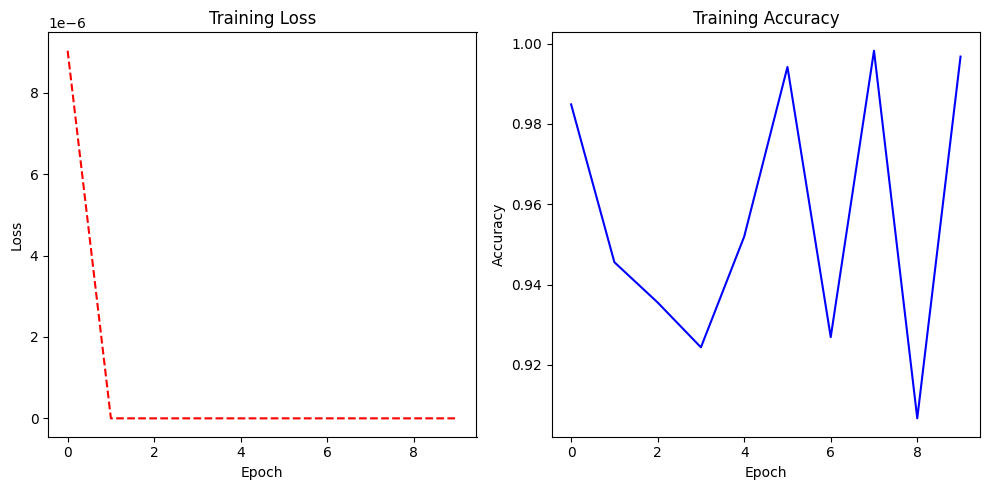

Training History:
           loss  accuracy
0  9.030440e-06  0.984874
1  3.921218e-12  0.945556
2  1.839411e-12  0.935522
3  1.224428e-12  0.924352
4  9.019677e-13  0.951935
5  7.074850e-13  0.994208
6  6.256862e-13  0.926898
7  5.137703e-13  0.998243
8  4.676835e-13  0.906663
9  3.627737e-13  0.996782
52981/52981 [==============================] - 165s 3ms/step
AUC Score (Class 1): 0.5
AUC Score (Class 2): 0.5
AUC Score (Class 3): 0.5
AUC Score (Class 4): 0.5
AUC Score (Class 5): 0.5
AUC Score (Class 6): 0.5
AUC Score (Class 7): 0.5
AUC Score (Class 8): 0.5
AUC Score (Class 9): 0.5
AUC Score (Class 10): 0.5
AUC Score (Class 11): 0.5
AUC Score (Class 12): 0.5
AUC Score (Class 13): 0.5
AUC Score (Class 14): 0.5
AUC Score (Class 15): 0.5
AUC Score (Class 16): 0.5
AUC Score (Class 17): 0.5
AUC Score (Class 18): 0.5
AUC Score (Class 19): 0.5
AUC Score (Class 20): 0.5
AUC Score (Class 21): 0.5
AUC Score (Class 22): 0.5
AUC Score (Class 23): 0.5
AUC Score (Class 24): 0.5
AUC Score (Class 25)

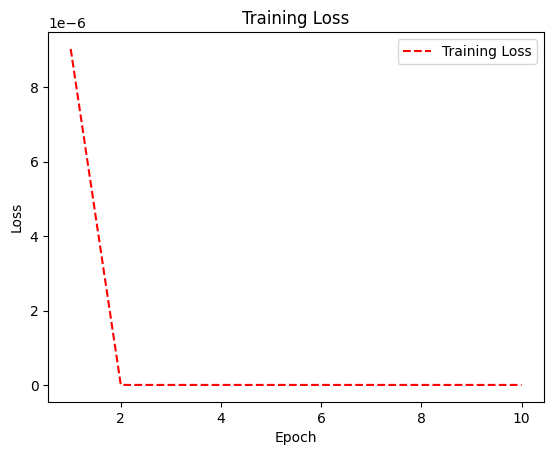

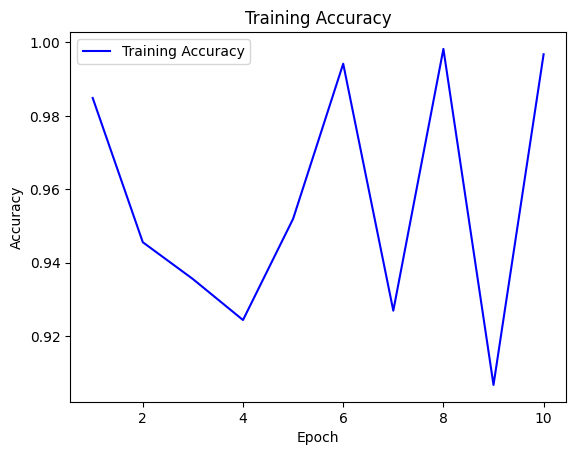

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from keras.optimizers import SGD, Adam
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.model_selection import train_test_split
import os
import chardet
import pandas as pd
from keras import backend as K
from tqdm import tqdm
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

# Define the dictionary to store the key-to-index mapping
key_to_index = {
    'D0': 0, 'D5': 1, 'Return': 2, 'LMenu': 3, 'Tab': 4, 'LShiftKey': 5, 'M': 6, 'Y': 7, 'Space': 8,
    'S': 9, 'E': 10, 'D': 11, 'O': 12, 'NumPad4': 13, 'A': 14, 'R': 15, 'OemPeriod': 16, 'L': 17,
    'N': 18, 'Oem7': 19, 'K': 20, 'P': 21, 'I': 22, 'G': 23, 'U': 24, 'T': 25, 'F': 26,
    'LControlKey': 27, 'NewKey1': 28, 'H': 29
}

# Read the data files
data_folder = '/content/drive/MyDrive/dataset'

# Create a list to store the data samples
data_list = []

# Load data from sessions s0 and s1 as training data
train_sessions = ['s0', 's1']
for session in train_sessions:
    session_folder = os.path.join(data_folder, session)
    for root, dirs, files in os.walk(session_folder):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'rb') as f:
                    try:
                        raw_data = f.read()
                        encoding = chardet.detect(raw_data)['encoding']
                        lines = raw_data.decode(encoding, errors='ignore').splitlines()
                        for line in lines:
                            parts = line.strip().split()
                            if len(parts) == 3:
                                key, event_type, timestamp = parts
                                data_list.append((key, event_type, timestamp))
                    except UnicodeDecodeError:
                        print(f"Error decoding file: {file_path}. Skipping file.")

# Create the input data array
num_samples = len(data_list)
num_features = len(key_to_index)
print("Number of data samples:", num_samples)
print("Number of features:", num_features)
input_data = np.zeros((num_samples, num_features))
for i, sample in tqdm(enumerate(data_list), total=num_samples, desc='Preprocessing'):
    key, _, _ = sample
    if key in key_to_index:
        input_data[i, key_to_index[key]] = 1

# Load data from session s2 as test data
test_session = 's2'
test_session_folder = os.path.join(data_folder, test_session)
test_data_list = []
for root, dirs, files in os.walk(test_session_folder):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                try:
                    raw_data = f.read()
                    encoding = chardet.detect(raw_data)['encoding']
                    lines = raw_data.decode(encoding, errors='ignore').splitlines()
                    for line in lines:
                        parts = line.strip().split()
                        if len(parts) == 3:
                            key, event_type, timestamp = parts
                            test_data_list.append((key, event_type, timestamp))
                except UnicodeDecodeError:
                    print(f"Error decoding file: {file_path}. Skipping file.")

# Create the test data array
num_test_samples = len(test_data_list)
test_input_data = np.zeros((num_test_samples, num_features))
for i, sample in tqdm(enumerate(test_data_list), total=num_test_samples, desc='Preprocessing Test Data'):
    key, _, _ = sample
    if key in key_to_index:
        test_input_data[i, key_to_index[key]] = 1

# Split the dataset into training and testing sets
if num_samples > 0:
    x_train, _, y_train, _ = train_test_split(input_data, np.zeros(num_samples), test_size=0.2, random_state=42)
else:
    raise ValueError("No data samples found. Adjust the dataset or check the data preprocessing step.")

# Reshape the input data
x_train = np.expand_dims(x_train, axis=2)
test_input_data = np.expand_dims(test_input_data, axis=2)

# Define input shape
input_shape = (num_features, 1)

# Define hyperparameters
batch_size = 64
num_epochs = 10
margin = 1  # Margin for the contrastive loss function

# Define the Siamese CNN model architecture
def siamese_cnn(input_a, input_b):
    # Convolutional layers for input A
    conv_a = Conv1D(filters=64, kernel_size=3, activation='relu')(input_a)
    pool_a = MaxPooling1D(pool_size=2)(conv_a)
    conv_a = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_a)
    pool_a = MaxPooling1D(pool_size=2)(conv_a)
    conv_a = Conv1D(filters=128, kernel_size=3, activation='relu')(pool_a)
    pool_a = MaxPooling1D(pool_size=2)(conv_a)
    flatten_a = Flatten()(pool_a)
    dropout_a = Dropout(0.5)(flatten_a)

    # Convolutional layers for input B
    conv_b = Conv1D(filters=64, kernel_size=3, activation='relu')(input_b)
    pool_b = MaxPooling1D(pool_size=2)(conv_b)
    conv_b = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_b)
    pool_b = MaxPooling1D(pool_size=2)(conv_b)
    conv_b = Conv1D(filters=128, kernel_size=3, activation='relu')(pool_b)
    pool_b = MaxPooling1D(pool_size=2)(conv_b)
    flatten_b = Flatten()(pool_b)
    dropout_b = Dropout(0.5)(flatten_b)

    # Concatenate the flattened outputs
    merged = concatenate([dropout_a, dropout_b])

    # Dense layers
    dense1 = Dense(128, activation='sigmoid')(merged)
    dense1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='sigmoid')(dense1)
    output = Dense(2, activation='sigmoid')(dense2)

    # Define the model
    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Build the Siamese CNN model
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
model = siamese_cnn(input_a, input_b)

# Define the contrastive loss function
def contrastive_loss(y_true, y_pred):
    square_pred = K.square(1 - y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

learning_rate = 0.01
#momentum = 0.99
# Compile the model with contrastive loss
optimizer = Adam(lr=learning_rate)
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit([x_train, x_train], y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1)

elapsed_time = time.time() - start_time
print("Training Time:", elapsed_time, "seconds")

# Convert training history to pandas DataFrame
history_df = pd.DataFrame(history.history)

# Plotting the training loss and accuracy
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], 'b-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

# Print the training history as a table
print("Training History:")
print(history_df)

# Evaluate the model
predictions = model.predict([test_input_data, test_input_data])
predictions = predictions.flatten()

# Create ground truth labels for evaluation
dataset_path = "/content/drive/MyDrive/dataset/s2"

baseline_folder = os.path.join(dataset_path, "baseline")
rotation_folder = os.path.join(dataset_path, "rotation")

# Extract ground truth labels for the baseline subset
baseline_files = os.listdir(baseline_folder)
baseline_labels = [int(filename[:3]) for filename in baseline_files]

# Extract ground truth labels for the rotation subset
rotation_files = os.listdir(rotation_folder)
rotation_labels = [int(filename[:3]) for filename in rotation_files]

ground_truth_labels = baseline_labels + rotation_labels
num_classes = len(np.unique(ground_truth_labels))

# Encode the ground truth labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(ground_truth_labels)

auc_scores = []
for class_idx in range(num_classes):
    class_labels = np.zeros_like(predictions)
    class_labels[np.where(encoded_labels == class_idx)] = 1
    class_probs = predictions
    auc_score = roc_auc_score(class_labels, class_probs)
    auc_scores.append(auc_score)

# Compute the mean AUC score
mean_auc_score = np.mean(auc_scores)

# Print the AUC scores
for class_idx, auc_score in enumerate(auc_scores):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"AUC Score (Class {class_name}): {auc_score}")

# Print the mean AUC score
print("Mean AUC Score:", mean_auc_score)

# Plotting the training loss and accuracy
import matplotlib.pyplot as plt

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize the training loss
plt.plot(epoch_count, training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Visualize the training accuracy
plt.plot(epoch_count, training_accuracy, 'b-')
plt.legend(['Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()
